# Essay Writer
Develop an agent for essay writing, replicating the workflow of a researcher working on this task.

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [6]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [7]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [8]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [10]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [12]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [13]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [15]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [18]:
builder = StateGraph(AgentState)

In [19]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
builder.set_entry_point("planner")

In [21]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
graph = builder.compile(checkpointer=memory)

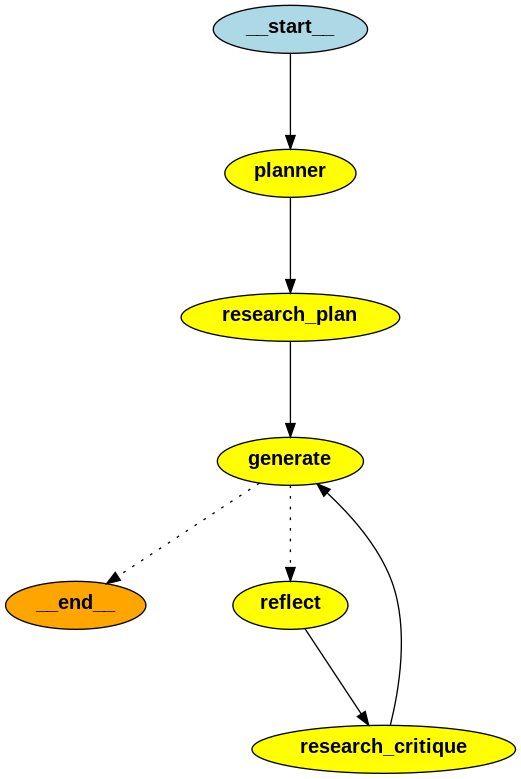

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Performance\n    E. Adoption and popularity\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Implications for the future of blockchain technology\n    C. Final thoughts and recommendations\n\nNotes:\n- Ensure to provide clear definitions and explanations of both Langchain and Langsmith.\n- Include specific examples of real-world appl

{'research_critique': {'content': ['If you’re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor your pipelines, Langsmith is your go-to tool. In short, while Langchain excels at managing and scaling model workflows, Langsmith is designed for those times when you need deep visibility and control over large, complex AI systems in production. But if you’re managing a complex AI pipeline with multiple models that need debugging and orchestrating, Langsmith’s capabilities become essential. If you’re debugging complex AI models or managing large-scale workflows with multiple moving parts, Langsmith’s advanced debugging and orchestration features will be indispensable. Additionally, if you’re working on cross-platform model deployments — say, running models on-prem and in the cloud simultaneously — Langsmith offers better orchestration and monitoring tools to handle the complexity.', "In this blog, we'll delve into the differences between 

## Essay Writer Interface

In [26]:
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore", message=".*TqdmWarning.*")
from dotenv import load_dotenv

_ = load_dotenv()

from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel
from tavily import TavilyClient
import os
import sqlite3

class AgentState(TypedDict):
    task: str
    lnode: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    queries: List[str]
    revision_number: int
    max_revisions: int
    count: Annotated[int, operator.add]


class Queries(BaseModel):
    queries: List[str]
    
class ewriter():
    def __init__(self):
        self.model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.PLAN_PROMPT = ("You are an expert writer tasked with writing a high level outline of a short 3 paragraph essay. "
                            "Write such an outline for the user provided topic. Give the three main headers of an outline of "
                             "the essay along with any relevant notes or instructions for the sections. ")
        self.WRITER_PROMPT = ("You are an essay assistant tasked with writing excellent 3 paragraph essays. "
                              "Generate the best essay possible for the user's request and the initial outline. "
                              "If the user provides critique, respond with a revised version of your previous attempts. "
                              "Utilize all the information below as needed: \n"
                              "------\n"
                              "{content}")
        self.RESEARCH_PLAN_PROMPT = ("You are a researcher charged with providing information that can "
                                     "be used when writing the following essay. Generate a list of search "
                                     "queries that will gather "
                                     "any relevant information. Only generate 3 queries max.")
        self.REFLECTION_PROMPT = ("You are a teacher grading an 3 paragraph essay submission. "
                                  "Generate critique and recommendations for the user's submission. "
                                  "Provide detailed recommendations, including requests for length, depth, style, etc.")
        self.RESEARCH_CRITIQUE_PROMPT = ("You are a researcher charged with providing information that can "
                                         "be used when making any requested revisions (as outlined below). "
                                         "Generate a list of search queries that will gather any relevant information. "
                                         "Only generate 2 queries max.")
        self.tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
        builder = StateGraph(AgentState)
        builder.add_node("planner", self.plan_node)
        builder.add_node("research_plan", self.research_plan_node)
        builder.add_node("generate", self.generation_node)
        builder.add_node("reflect", self.reflection_node)
        builder.add_node("research_critique", self.research_critique_node)
        builder.set_entry_point("planner")
        builder.add_conditional_edges(
            "generate", 
            self.should_continue, 
            {END: END, "reflect": "reflect"}
        )
        builder.add_edge("planner", "research_plan")
        builder.add_edge("research_plan", "generate")
        builder.add_edge("reflect", "research_critique")
        builder.add_edge("research_critique", "generate")
        memory = SqliteSaver(conn=sqlite3.connect(":memory:", check_same_thread=False))
        self.graph = builder.compile(
            checkpointer=memory,
            interrupt_after=['planner', 'generate', 'reflect', 'research_plan', 'research_critique']
        )


    def plan_node(self, state: AgentState):
        messages = [
            SystemMessage(content=self.PLAN_PROMPT), 
            HumanMessage(content=state['task'])
        ]
        response = self.model.invoke(messages)
        return {"plan": response.content,
               "lnode": "planner",
                "count": 1,
               }
    def research_plan_node(self, state: AgentState):
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_PLAN_PROMPT),
            HumanMessage(content=state['task'])
        ])
        content = state['content'] or []  # add to content
        for q in queries.queries:
            response = self.tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"content": content,
                "queries": queries.queries,
               "lnode": "research_plan",
                "count": 1,
               }
    def generation_node(self, state: AgentState):
        content = "\n\n".join(state['content'] or [])
        user_message = HumanMessage(
            content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
        messages = [
            SystemMessage(
                content=self.WRITER_PROMPT.format(content=content)
            ),
            user_message
            ]
        response = self.model.invoke(messages)
        return {
            "draft": response.content, 
            "revision_number": state.get("revision_number", 1) + 1,
            "lnode": "generate",
            "count": 1,
        }
    def reflection_node(self, state: AgentState):
        messages = [
            SystemMessage(content=self.REFLECTION_PROMPT), 
            HumanMessage(content=state['draft'])
        ]
        response = self.model.invoke(messages)
        return {"critique": response.content,
               "lnode": "reflect",
                "count": 1,
        }
    def research_critique_node(self, state: AgentState):
        queries = self.model.with_structured_output(Queries).invoke([
            SystemMessage(content=self.RESEARCH_CRITIQUE_PROMPT),
            HumanMessage(content=state['critique'])
        ])
        content = state['content'] or []
        for q in queries.queries:
            response = self.tavily.search(query=q, max_results=2)
            for r in response['results']:
                content.append(r['content'])
        return {"content": content,
               "lnode": "research_critique",
                "count": 1,
        }
    def should_continue(self, state):
        if state["revision_number"] > state["max_revisions"]:
            return END
        return "reflect"

import gradio as gr
import time

class writer_gui( ):
    def __init__(self, graph, share=False):
        self.graph = graph
        self.share = share
        self.partial_message = ""
        self.response = {}
        self.max_iterations = 10
        self.iterations = []
        self.threads = []
        self.thread_id = -1
        self.thread = {"configurable": {"thread_id": str(self.thread_id)}}
        #self.sdisps = {} #global    
        self.demo = self.create_interface()

    def run_agent(self, start,topic,stop_after):
        #global partial_message, thread_id,thread
        #global response, max_iterations, iterations, threads
        if start:
            self.iterations.append(0)
            config = {'task': topic,"max_revisions": 2,"revision_number": 0,
                      'lnode': "", 'planner': "no plan", 'draft': "no draft", 'critique': "no critique", 
                      'content': ["no content",], 'queries': "no queries", 'count':0}
            self.thread_id += 1  # new agent, new thread
            self.threads.append(self.thread_id)
        else:
            config = None
        self.thread = {"configurable": {"thread_id": str(self.thread_id)}}
        while self.iterations[self.thread_id] < self.max_iterations:
            self.response = self.graph.invoke(config, self.thread)
            self.iterations[self.thread_id] += 1
            self.partial_message += str(self.response)
            self.partial_message += f"\n------------------\n\n"
            ## fix
            lnode,nnode,_,rev,acount = self.get_disp_state()
            yield self.partial_message,lnode,nnode,self.thread_id,rev,acount
            config = None #need
            #print(f"run_agent:{lnode}")
            if not nnode:  
                #print("Hit the end")
                return
            if lnode in stop_after:
                #print(f"stopping due to stop_after {lnode}")
                return
            else:
                #print(f"Not stopping on lnode {lnode}")
                pass
        return
    
    def get_disp_state(self,):
        current_state = self.graph.get_state(self.thread)
        lnode = current_state.values["lnode"]
        acount = current_state.values["count"]
        rev = current_state.values["revision_number"]
        nnode = current_state.next
        #print  (lnode,nnode,self.thread_id,rev,acount)
        return lnode,nnode,self.thread_id,rev,acount
    
    def get_state(self,key):
        current_values = self.graph.get_state(self.thread)
        if key in current_values.values:
            lnode,nnode,self.thread_id,rev,astep = self.get_disp_state()
            new_label = f"last_node: {lnode}, thread_id: {self.thread_id}, rev: {rev}, step: {astep}"
            return gr.update(label=new_label, value=current_values.values[key])
        else:
            return ""  
    
    def get_content(self,):
        current_values = self.graph.get_state(self.thread)
        if "content" in current_values.values:
            content = current_values.values["content"]
            lnode,nnode,thread_id,rev,astep = self.get_disp_state()
            new_label = f"last_node: {lnode}, thread_id: {self.thread_id}, rev: {rev}, step: {astep}"
            return gr.update(label=new_label, value="\n\n".join(item for item in content) + "\n\n")
        else:
            return ""  
    
    def update_hist_pd(self,):
        #print("update_hist_pd")
        hist = []
        # curiously, this generator returns the latest first
        for state in self.graph.get_state_history(self.thread):
            if state.metadata['step'] < 1:
                continue
            thread_ts = state.config['configurable']['thread_ts']
            tid = state.config['configurable']['thread_id']
            count = state.values['count']
            lnode = state.values['lnode']
            rev = state.values['revision_number']
            nnode = state.next
            st = f"{tid}:{count}:{lnode}:{nnode}:{rev}:{thread_ts}"
            hist.append(st)
        return gr.Dropdown(label="update_state from: thread:count:last_node:next_node:rev:thread_ts", 
                           choices=hist, value=hist[0],interactive=True)
    
    def find_config(self,thread_ts):
        for state in self.graph.get_state_history(self.thread):
            config = state.config
            if config['configurable']['thread_ts'] == thread_ts:
                return config
        return(None)
            
    def copy_state(self,hist_str):
        ''' result of selecting an old state from the step pulldown. Note does not change thread. 
             This copies an old state to a new current state. 
        '''
        thread_ts = hist_str.split(":")[-1]
        #print(f"copy_state from {thread_ts}")
        config = self.find_config(thread_ts)
        #print(config)
        state = self.graph.get_state(config)
        self.graph.update_state(self.thread, state.values, as_node=state.values['lnode'])
        new_state = self.graph.get_state(self.thread)  #should now match
        new_thread_ts = new_state.config['configurable']['thread_ts']
        tid = new_state.config['configurable']['thread_id']
        count = new_state.values['count']
        lnode = new_state.values['lnode']
        rev = new_state.values['revision_number']
        nnode = new_state.next
        return lnode,nnode,new_thread_ts,rev,count
    
    def update_thread_pd(self,):
        #print("update_thread_pd")
        return gr.Dropdown(label="choose thread", choices=threads, value=self.thread_id,interactive=True)
    
    def switch_thread(self,new_thread_id):
        #print(f"switch_thread{new_thread_id}")
        self.thread = {"configurable": {"thread_id": str(new_thread_id)}}
        self.thread_id = new_thread_id
        return 
    
    def modify_state(self,key,asnode,new_state):
        ''' gets the current state, modifes a single value in the state identified by key, and updates state with it.
        note that this will create a new 'current state' node. If you do this multiple times with different keys, it will create
        one for each update. Note also that it doesn't resume after the update
        '''
        current_values = self.graph.get_state(self.thread)
        current_values.values[key] = new_state
        self.graph.update_state(self.thread, current_values.values,as_node=asnode)
        return


    def create_interface(self):
        with gr.Blocks(theme=gr.themes.Default(spacing_size='sm',text_size="sm")) as demo:
            
            def updt_disp():
                ''' general update display on state change '''
                current_state = self.graph.get_state(self.thread)
                hist = []
                # curiously, this generator returns the latest first
                for state in self.graph.get_state_history(self.thread):
                    if state.metadata['step'] < 1:  #ignore early states
                        continue
                    s_thread_ts = state.config['configurable']['thread_ts']
                    s_tid = state.config['configurable']['thread_id']
                    s_count = state.values['count']
                    s_lnode = state.values['lnode']
                    s_rev = state.values['revision_number']
                    s_nnode = state.next
                    st = f"{s_tid}:{s_count}:{s_lnode}:{s_nnode}:{s_rev}:{s_thread_ts}"
                    hist.append(st)
                if not current_state.metadata: #handle init call
                    return{}
                else:
                    return {
                        topic_bx : current_state.values["task"],
                        lnode_bx : current_state.values["lnode"],
                        count_bx : current_state.values["count"],
                        revision_bx : current_state.values["revision_number"],
                        nnode_bx : current_state.next,
                        threadid_bx : self.thread_id,
                        thread_pd : gr.Dropdown(label="choose thread", choices=self.threads, value=self.thread_id,interactive=True),
                        step_pd : gr.Dropdown(label="update_state from: thread:count:last_node:next_node:rev:thread_ts", 
                               choices=hist, value=hist[0],interactive=True),
                    }
            def get_snapshots():
                new_label = f"thread_id: {self.thread_id}, Summary of snapshots"
                sstate = ""
                for state in self.graph.get_state_history(self.thread):
                    for key in ['plan', 'draft', 'critique']:
                        if key in state.values:
                            state.values[key] = state.values[key][:80] + "..."
                    if 'content' in state.values:
                        for i in range(len(state.values['content'])):
                            state.values['content'][i] = state.values['content'][i][:20] + '...'
                    if 'writes' in state.metadata:
                        state.metadata['writes'] = "not shown"
                    sstate += str(state) + "\n\n"
                return gr.update(label=new_label, value=sstate)

            def vary_btn(stat):
                #print(f"vary_btn{stat}")
                return(gr.update(variant=stat))
            
            with gr.Tab("Agent"):
                with gr.Row():
                    topic_bx = gr.Textbox(label="Essay Topic", value="Pizza Shop")
                    gen_btn = gr.Button("Generate Essay", scale=0,min_width=80, variant='primary')
                    cont_btn = gr.Button("Continue Essay", scale=0,min_width=80)
                with gr.Row():
                    lnode_bx = gr.Textbox(label="last node", min_width=100)
                    nnode_bx = gr.Textbox(label="next node", min_width=100)
                    threadid_bx = gr.Textbox(label="Thread", scale=0, min_width=80)
                    revision_bx = gr.Textbox(label="Draft Rev", scale=0, min_width=80)
                    count_bx = gr.Textbox(label="count", scale=0, min_width=80)
                with gr.Accordion("Manage Agent", open=False):
                    checks = list(self.graph.nodes.keys())
                    checks.remove('__start__')
                    stop_after = gr.CheckboxGroup(checks,label="Interrupt After State", value=checks, scale=0, min_width=400)
                    with gr.Row():
                        thread_pd = gr.Dropdown(choices=self.threads,interactive=True, label="select thread", min_width=120, scale=0)
                        step_pd = gr.Dropdown(choices=['N/A'],interactive=True, label="select step", min_width=160, scale=1)
                live = gr.Textbox(label="Live Agent Output", lines=5, max_lines=5)
        
                # actions
                sdisps =[topic_bx,lnode_bx,nnode_bx,threadid_bx,revision_bx,count_bx,step_pd,thread_pd]
                thread_pd.input(self.switch_thread, [thread_pd], None).then(
                                fn=updt_disp, inputs=None, outputs=sdisps)
                step_pd.input(self.copy_state,[step_pd],None).then(
                              fn=updt_disp, inputs=None, outputs=sdisps)
                gen_btn.click(vary_btn,gr.Number("secondary", visible=False), gen_btn).then(
                              fn=self.run_agent, inputs=[gr.Number(True, visible=False),topic_bx,stop_after], outputs=[live],show_progress=True).then(
                              fn=updt_disp, inputs=None, outputs=sdisps).then( 
                              vary_btn,gr.Number("primary", visible=False), gen_btn).then(
                              vary_btn,gr.Number("primary", visible=False), cont_btn)
                cont_btn.click(vary_btn,gr.Number("secondary", visible=False), cont_btn).then(
                               fn=self.run_agent, inputs=[gr.Number(False, visible=False),topic_bx,stop_after], 
                               outputs=[live]).then(
                               fn=updt_disp, inputs=None, outputs=sdisps).then(
                               vary_btn,gr.Number("primary", visible=False), cont_btn)
        
            with gr.Tab("Plan"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                    modify_btn = gr.Button("Modify")
                plan = gr.Textbox(label="Plan", lines=10, interactive=True)
                refresh_btn.click(fn=self.get_state, inputs=gr.Number("plan", visible=False), outputs=plan)
                modify_btn.click(fn=self.modify_state, inputs=[gr.Number("plan", visible=False),
                                                          gr.Number("planner", visible=False), plan],outputs=None).then(
                                 fn=updt_disp, inputs=None, outputs=sdisps)
            with gr.Tab("Research Content"):
                refresh_btn = gr.Button("Refresh")
                content_bx = gr.Textbox(label="content", lines=10)
                refresh_btn.click(fn=self.get_content, inputs=None, outputs=content_bx)
            with gr.Tab("Draft"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                    modify_btn = gr.Button("Modify")
                draft_bx = gr.Textbox(label="draft", lines=10, interactive=True)
                refresh_btn.click(fn=self.get_state, inputs=gr.Number("draft", visible=False), outputs=draft_bx)
                modify_btn.click(fn=self.modify_state, inputs=[gr.Number("draft", visible=False),
                                                          gr.Number("generate", visible=False), draft_bx], outputs=None).then(
                                fn=updt_disp, inputs=None, outputs=sdisps)
            with gr.Tab("Critique"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                    modify_btn = gr.Button("Modify")
                critique_bx = gr.Textbox(label="Critique", lines=10, interactive=True)
                refresh_btn.click(fn=self.get_state, inputs=gr.Number("critique", visible=False), outputs=critique_bx)
                modify_btn.click(fn=self.modify_state, inputs=[gr.Number("critique", visible=False),
                                                          gr.Number("reflect", visible=False), 
                                                          critique_bx], outputs=None).then(
                                fn=updt_disp, inputs=None, outputs=sdisps)
            with gr.Tab("StateSnapShots"):
                with gr.Row():
                    refresh_btn = gr.Button("Refresh")
                snapshots = gr.Textbox(label="State Snapshots Summaries")
                refresh_btn.click(fn=get_snapshots, inputs=None, outputs=snapshots)
        return demo

    def launch(self, share=None):
        if port := os.getenv("PORT1"):
            self.demo.launch(share=True, server_port=int(port), server_name="0.0.0.0")
        else:
            self.demo.launch(share=self.share)


In [27]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

IMPORTANT: You are using gradio version 4.31.3, however version 4.44.1 is available, please upgrade.
--------
Running on local URL:  http://0.0.0.0:8080
Running on public URL: https://e3f79d6cc6f165c2ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
